  <style>
    .container {
      display: flex;
      justify-content: space-between;
      align-items: center;
    }

    .text {
      width: 95%;
       text-align: center;
    }

    .image {
      width: 5%;
      text-align: center; 
    }

    
    .image img {
      max-width: 100%;
      height: auto;
    }
  </style> 
  
  <div class="container">
    <div class="image">
      <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Logo_KIT.svg/1200px-Logo_KIT.svg.png" width=100 height=50/>
    </div>
        <div class="text">
      <h1> Medical Image Processing and Navigation 2024/25</h1>
    </div>
  </div>


---

<center>
<h2>Multi Atlas Based Segmentation (MABS)</h2> 
<center><img src="https://d3i71xaburhd42.cloudfront.net/6fb13081e034b919f52b30a1b953328349c0c877/2-Figure1-1.png"></center>

---

<center>
Lecturer: <b><i>Ciro Benito Raggio</i></b> 
<br/>
<a><href>https://www.ibt.kit.edu/english/Raggio_C.php</href></a>

Atlas-based segmentation exploits knowledge from previously labeled training images to segment the target image. 

Multi-atlas segmentation methods map all labeled images onto the target image, which helps to reduce segmentation errors.

In [1]:
import numpy as np
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
def bin_img(img):
    img = img.astype(np.float32)
    img -= img.min()
    img /= img.max()
    return img.astype(np.uint8)

## Choose the structure to segment

In [3]:
print(f"Structures available: {os.listdir('./MABS/patient/')}")

Structures available: ['CT.nrrd', 'left_parotid.nrrd', 'right_parotid.nrrd', 'mandible.nrrd']


In [4]:
structure = "mandible"
selected_slice = 70

Start by reading the patient's CT and reference frame

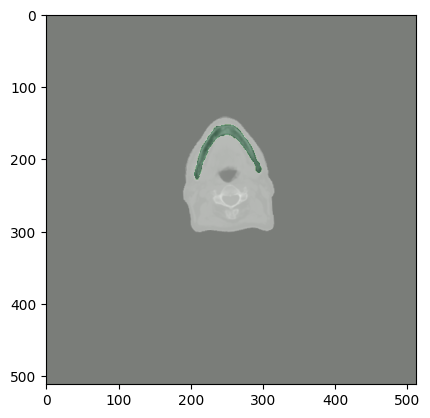

In [5]:
ct_sikt = sitk.ReadImage("./MABS/patient/CT.nrrd")
ct = sitk.GetArrayFromImage(ct_sikt)

structure_sitk = sitk.ReadImage(f"./MABS/patient/{structure}.nrrd")
structure_bin = bin_img(sitk.GetArrayFromImage(structure_sitk))

plt.imshow(ct[selected_slice, :, :], cmap="gray")
plt.imshow(structure_bin[selected_slice, :, :], cmap="Greens", alpha=0.5)

## Step 1 - Load the structures of interest from the atlases available

In [6]:
deformed_structs = []
deformed_sitk_structs = []

atlases_path = "./MABS/"

# Filter all the atlases in the specified folder
atlases = list(filter(lambda dirname: "atl" in dirname,
               os.listdir(atlases_path)))

print(f"Found {len(atlases)} atlases!\nAtlases' names:{atlases}")

for atlas_index in range(1, len(atlases)+1):
    def_stru_sitk = sitk.ReadImage(
        f"./MABS/atl{atlas_index}/{structure}.nrrd")
    deformed_sitk_structs.append(def_stru_sitk)
    def_stru = bin_img(sitk.GetArrayFromImage(def_stru_sitk))
    deformed_structs.append(def_stru)

print(f"Found {len(deformed_structs)} deformed structures!")

Found 6 atlases!
Atlases' names:['atl4', 'atl3', 'atl2', 'atl5', 'atl6', 'atl1']
Found 6 deformed structures!


Let's see what structures are loaded by the atlases

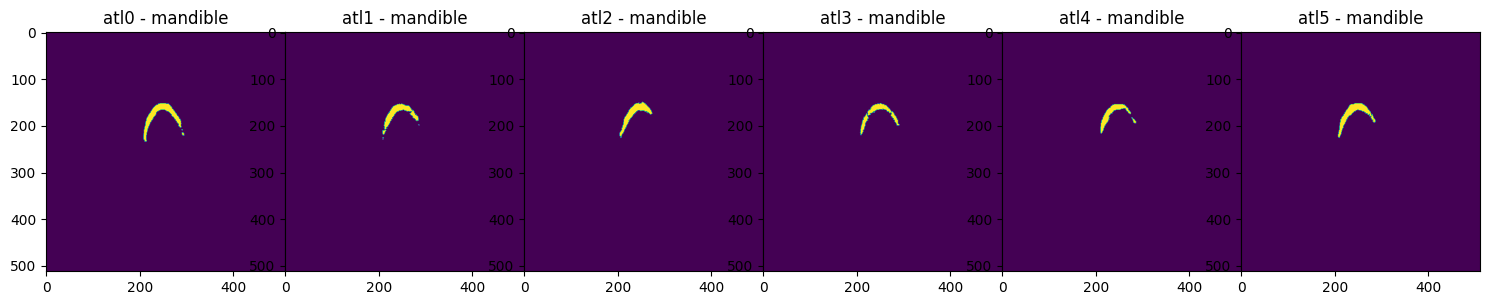

In [7]:
f, axarr = plt.subplots(1, len(deformed_structs), figsize=(15, 10))

for i, deformed_struct in enumerate(deformed_structs):
    img = axarr[i].imshow(deformed_struct[selected_slice, :, :])
    axarr[i].set_title(f"atl{i} - {structure}")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

## Step 2 - Majority voting

<center><img src="https://1.bp.blogspot.com/-wnwx3mulVkU/YKo9a7ocMqI/AAAAAAAACZQ/h8lBb3BNFr8ZN0rNHkpYV6pZfoFk-ugzwCLcBGAsYHQ/s760/Majority.png" /></center>

To perform majority voting, we will iterate over all the deformed structures, accumulating votes for each voxel.

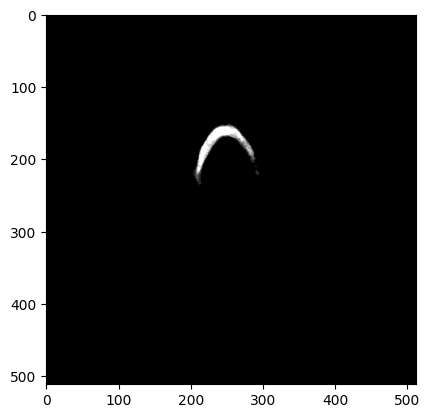

In [8]:
voted_structs = np.zeros_like(structure_bin)
for def_stru in deformed_structs:
    voted_structs += def_stru

plt.imshow(voted_structs[selected_slice, :, :], cmap="gray")

At this point a strategy could be to understand what the maximum votes are for a voxel, which in our case corresponds to the total number of deformed structures available

In [9]:
voted_structs.max()

6

Knowing that, in this case, a voxel can have been voted on a maximum of 6 times, we can choose to form the final mask only from the voxels that have been voted on at least N times

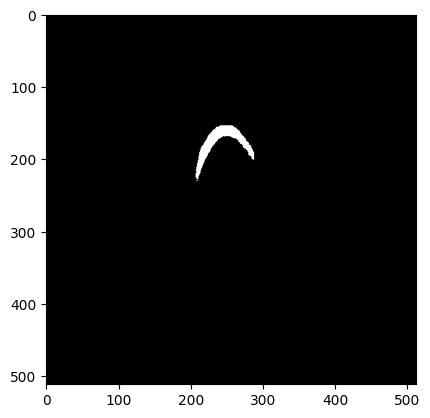

In [10]:
min_votes = 2
threshold_voted_structure = voted_structs >= min_votes
plt.imshow(threshold_voted_structure[selected_slice, :, :], cmap="gray")

## Simultaneous Truth and Performance Level Estimation (STAPLE)

The STAPLE procedure uses the **expectation-maximization algorithm** to iteratively estimate the quality of the individual segmentations. The final segmentation is then computed with these individual segmentation qualities taken into account by weighting the decisions made by a reliable segmentation algorithm higher than ones made by a less reliable algorithm.

SimpleITK makes the STAPLE procedure available under the name STAPLEImageFilter. We can use it to automate majority voting and achieve final segmentation.

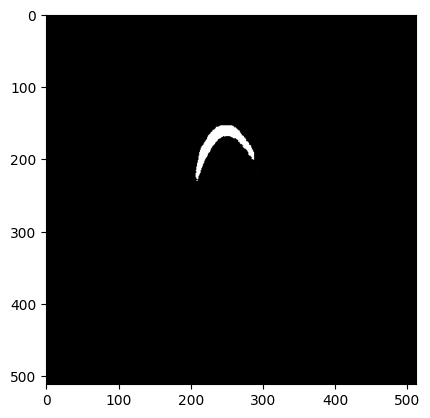

In [11]:
staple_procedure = sitk.STAPLEImageFilter()

# In input we must pass the deformed structures as SITK objects and not as arrays
staple_sitk_voted = staple_procedure.Execute(deformed_sitk_structs)

# Now we can convert the object obtained into an array with SITK and display the result
staple_voted = sitk.GetArrayFromImage(staple_sitk_voted)

plt.imshow(staple_voted[selected_slice, :, :], cmap="gray")

We can compare the two results obtained on the starting CT

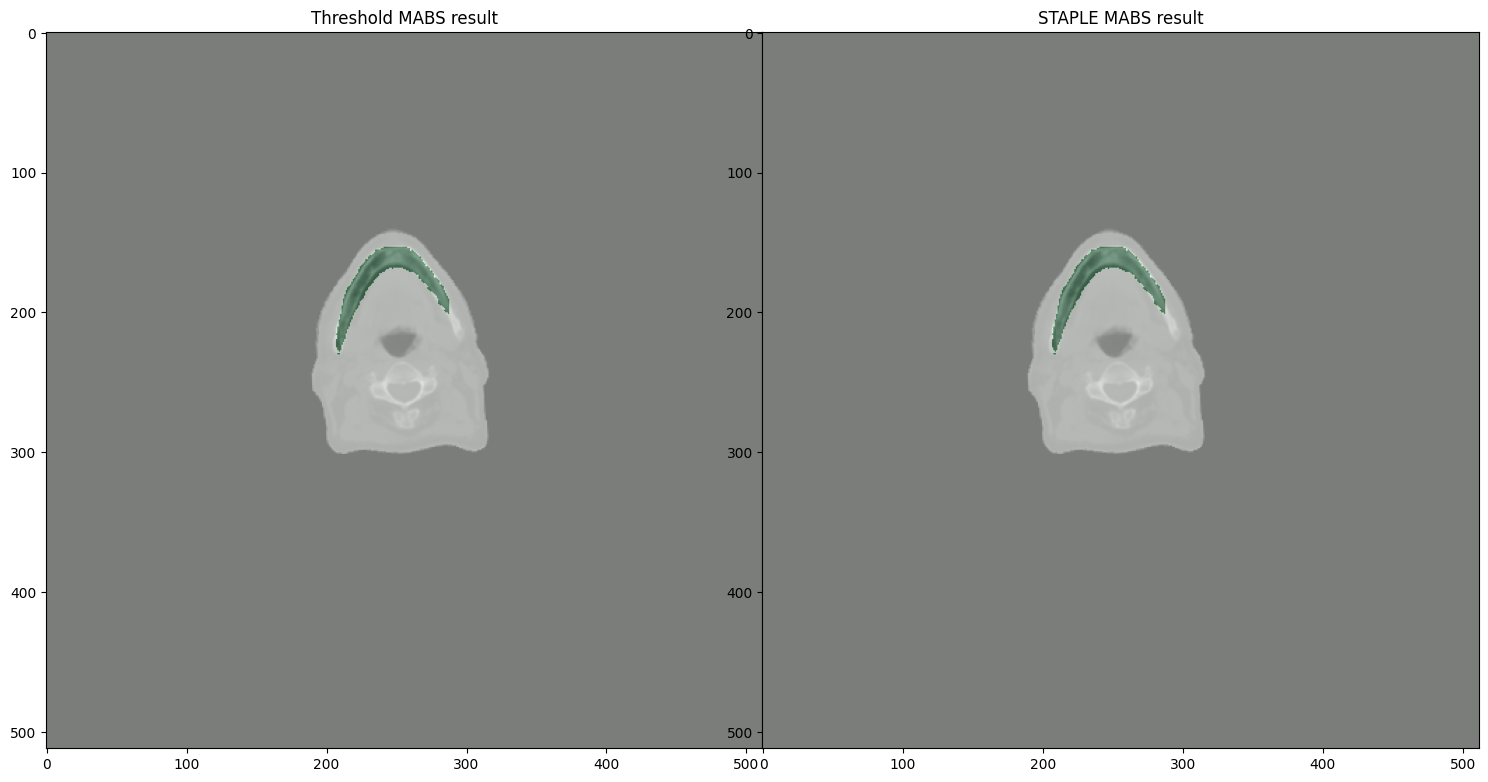

In [12]:
f, axarr = plt.subplots(1, 2, figsize=(15, 10))

img = axarr[0].imshow(ct[selected_slice, :, :], cmap="gray")
img = axarr[0].imshow(threshold_voted_structure.astype(
    int)[selected_slice, :, :], cmap="Greens", alpha=0.5)
axarr[0].set_title(f"Threshold MABS result")

img = axarr[1].imshow(ct[selected_slice, :, :], cmap="gray")
img = axarr[1].imshow(staple_voted[selected_slice, :, :],
                      cmap="Greens", alpha=0.5)
axarr[1].set_title(f"STAPLE MABS result")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# Threshold vs. STAPLE: who is better?
We have therefore obtained two apparently very similar results, but which of these two best adapts to the patient's original structure?
We can find out thanks to the Jaccard (IoU) and Dice coefficients!

<center><img src="https://ilmonteux.github.io/assets/images/segmentation/metrics_iou_dice.png" /></center> 

We calculate the Dice between the segmentation obtained with the thresholding and the patient's structure.
SITK also makes this metric available, we just need to instantiate the LabelOverlapMeasuresImageFilter type overlapper and call the getDiceCoefficient method.

In [13]:
def dice(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 4)
    return dice

In [14]:
def jaccard(im1, im2):
    """
    Computes the Jaccard metric, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    jaccard : float
        Jaccard metric returned is a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0

    Notes
    -----
    The order of inputs for `jaccard` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1)
    im2 = np.asarray(im2)

    if im1.shape != im2.shape:
        raise ValueError(
            "Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    union = np.logical_or(im1, im2)

    return intersection.sum() / float(union.sum())

In [15]:
gt_sitk = sitk.ReadImage(f"./MABS/patient/{structure}.nrrd")
gt_array = sitk.GetArrayFromImage(gt_sitk)
bin_staple_voted = bin_img(staple_voted)

threshold_mabs_dice = dice(gt_array, threshold_voted_structure.astype(int))
staple_mabs_dice = dice(gt_array, bin_staple_voted)

print(
    f"Threshold MABS Dice coefficient: {threshold_mabs_dice}\nSTAPLE MABS Dice coefficient: {staple_mabs_dice}")

Threshold MABS Dice coefficient: 0.8189
STAPLE MABS Dice coefficient: 0.8205


In [16]:
threshold_mabs_iou = jaccard(gt_array, threshold_voted_structure.astype(int))
staple_mabs_iou = jaccard(gt_array, bin_staple_voted)

print(
    f"Threshold MABS Jaccard coefficient: {threshold_mabs_iou}\nSTAPLE MABS Jaccard coefficient: {staple_mabs_iou}")

Threshold MABS Jaccard coefficient: 0.6933593235518795
STAPLE MABS Jaccard coefficient: 0.6956920256645279


# Exercise 📚

Implement a method to determine the optimal number of votes needed to obtain the best results in multi-atlas segmentation, assessed by similarity metrics (Dice and Jaccard). Based on the results obtained for each structure and the time taken to run the algorithm, a total score will be calculated that equally weighs time and similarity performance.

In [23]:
from typing import Tuple
import SimpleITK as sitk
import os
import numpy as np
from time import time 

def get_best_threshold(gt_array, atlas_root, structures) -> Tuple[int, dict]:
    """Find the optimal number of votes to have the best result in terms of Dice and Jaccard.

    Args:
        gt_array (np.array): ground truth segmentation
        atlas_root
    Returns:
        optimal number of votes (int)
        metrics (dict): a dictionary containing the metrics
    """
    m = structures[0]
    l = structures[1]
    r = structures[2]
    
    # gt_bin_struc = np.zeros_like(structure_bin)
    gt_bin_struc = np.zeros((150, 512, 512))
    gt_bin = np.stack((gt_bin_struc, gt_bin_struc, gt_bin_struc), axis=0)
    
    # get the ground truth segmentations for all 3 structures
    for i, struc in enumerate(structures):
        struct_sitk = sitk.ReadImage(gt_array + struc + ".nrrd")  # "./MABS/patient/{structure}.nrrd"
        struct_bin = bin_img(sitk.GetArrayFromImage(struct_sitk))
        gt_bin[i] = struct_bin
    
    # Dictionary containing the shape of the numpy arrays for all three structures
    atl_bin = np.stack((gt_bin_struc, gt_bin_struc, gt_bin_struc, gt_bin_struc, gt_bin_struc, gt_bin_struc), axis=0)
    deformed_bin = {m: np.stack([np.zeros_like(gt_bin_struc) for _ in range(6)], axis=0), 
                    l: np.stack([np.zeros_like(gt_bin_struc) for _ in range(6)], axis=0), 
                    r: np.stack([np.zeros_like(gt_bin_struc) for _ in range(6)], axis=0)}
    
    atlases = list(filter(lambda dirname: "atl" in dirname,
                          sorted(os.scandir(atlas_root))))
    
    # get the atlas-based segmentations for all 3 structures
    for i in structures:
        for atlas_index in range(1, len(atlases)+1):
            def_struc_sitk = sitk.ReadImage(atlas_root + "atl" + str(atlas_index) + "/" + i + ".nrrd")  # "./MABS/atl{structure_index}/{structure}.nrrd"
            def_struc_bin = bin_img(sitk.GetArrayFromImage(def_struc_sitk))
            deformed_bin[i][atlas_index-1] = def_struc_bin
            
    threshold = [0, 0, 0]
    
    dice_score = [0, 0, 0]
    jaccard_score = [0, 0, 0]
    mean_score = [0, 0, 0]
    
    # For all structures, sum up the segmentations for all atlases compare pixels with threshold
    for i, struc in enumerate(structures):
        voted_structure = np.zeros_like(gt_bin[i])
        
        # for def_struc in deformed_bin[struc]:
            # voted_structure += def_struc
            # voted_structure = np.sum((voted_structure, def_struc), axis=0)
        
        voted_structure = np.sum(deformed_bin[struc], axis=0)
        
        # For each possible threshold, check whether dice/jaccard better than previous best threshold
        for min_votes in range(1, int(np.max(voted_structure)) + 1):
            threshold_voted_structure = np.zeros_like(gt_bin[i])
            threshold_voted_structure = voted_structure >= min_votes
            # threshold_voted_structure = np.where(voted_structure >= min_votes, voted_structure, 0)
            
            dice_struc = dice(gt_bin[i], threshold_voted_structure.astype(int))
            jaccard_struc = jaccard(gt_bin[i], threshold_voted_structure.astype(int))
            mean_struc = (dice_struc + jaccard_struc) / 2
            
            if mean_struc > mean_score[i]:
                mean_score[i] = mean_struc
                threshold[i] = min_votes
                dice_score[i] = dice_struc
                jaccard_score[i] = jaccard_struc
                
                min_votes_winner = min_votes
                
        threshold[i] = min_votes_winner
     
    # plt.figure()
    # plt.imshow(threshold_voted_struc[2][selected_slice, :, :], cmap="gray")
        
    votes_opt = {m: threshold[0], l: threshold[1], r: threshold[2]}
    metrics_opt = {m: dict(dice = dice_score[0], jaccard = jaccard_score[0]), 
                   l: dict(dice = dice_score[1], jaccard = jaccard_score[1]), 
                   r: dict(dice = dice_score[2], jaccard = jaccard_score[2])}
    return tuple((votes_opt, metrics_opt))

# get_best_threshold("./MABS/patient/", "./MABS/", structures)


In [24]:
structures = ["mandible", "left_parotid", "right_parotid"]
selected_slice = 71
start_time = time()
best_votes, best_scores = get_best_threshold("./MABS/patient/", "./MABS/", structures)
end_time = time()
execution_time = end_time - start_time

def calculate_total_score(results, execution_time, max_time=10.0) -> float:
    sim_scores = [(res['dice'] + res['jaccard']) / 2 for key,res in results.items()]
    avg_sim_score = sum(sim_scores) / len(sim_scores)  
    time_score = max(0, 1 - (execution_time / max_time))
    total_score = (avg_sim_score * 0.5) + (time_score * 0.5)
    return total_score * 100


print("Atlas-Based Segmentation Metrics:")

for structure in structures:
    print(f"Structure: {structure}")
    print(f"  Optimal Threshold: {best_votes[structure]}")
    print(f"  Best Scores: {best_scores[structure]}")
    
print(f"Execution Time: {execution_time:.2f} seconds")
print(calculate_total_score(best_scores, execution_time))

Atlas-Based Segmentation Metrics:
Structure: mandible
  Optimal Threshold: 2
  Best Scores: {'dice': 0.8189, 'jaccard': 0.6933593235518795}
Structure: left_parotid
  Optimal Threshold: 3
  Best Scores: {'dice': 0.8488, 'jaccard': 0.737292742593096}
Structure: right_parotid
  Optimal Threshold: 3
  Best Scores: {'dice': 0.8253, 'jaccard': 0.7025194401244168}
Execution Time: 24.19 seconds
38.5514292189116


## References
[Wachinger C, Golland P. Atlas-based under-segmentation. Med Image Comput Comput Assist Interv. 2014;17(Pt 1):315-22. doi: 10.1007/978-3-319-10404-1_40. PMID: 25333133; PMCID: PMC4219918.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4219918/#:~:text=Atlas%2Dbased%20segmentation%20exploits%20knowledge,6%2C8%2C11%5D.)

[Mitchell, H.B. (2010). STAPLE: Simultaneous Truth and Performance Level Estimation. In: Image Fusion. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-11216-4_21](https://link.springer.com/chapter/10.1007/978-3-642-11216-4_21)

[Jaccard coefficient](https://gist.github.com/JDWarner/6730886)